In [3]:
import os
import time
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from itertools import product
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')
excel_filename = "/content/drive/My Drive/SENG_533/storm_experiment_results.xlsx"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parameter values for iteration
num_cores_values = [1, 2, 4]           # CPU cores
driver_memory_values = ["2g", "4g", "8g"]  # Driver memory sizes
parallelism_values = [2, 4, 8]         # Parallelism levels
batch_interval = 0.5                   # Batch interval in seconds
dataset_path = "/content/drive/My Drive/SENG_533/Datasets/flights_sample_1k.csv"

pandas_data_file_lower = dataset_path.lower()
if "1k" in pandas_data_file_lower:
    file_size = "1k"
elif "500k" in pandas_data_file_lower:
    file_size = "500k"
elif "3m" in pandas_data_file_lower:
    file_size = "3m"
else:
    file_size = "unknown"



# Define Excel filename and columns for results (including new file_size column)
excel_filename = "/content/drive/My Drive/SENG_533/storm_experiment_results.xlsx"
columns = [
    "num_cores",
    "driver_memory",
    "parallelism",
    "batch_interval",
    "file_size",  # new column for file size category
    "train_duration_s",
    "train_count",
    "train_throughput_records_s",
    "pred_duration_s",
    "test_count",
    "pred_throughput_records_s",
    "rmse",
    "r2",
    "cpu_usage_start_percent",
    "cpu_usage_end_percent",
    "mem_used_at_start_mb",
    "mem_used_at_end_mb",
    "timestamp"
]

# Check if the Excel file exists; load existing data or create new DataFrame
if os.path.exists(excel_filename):
    results_df = pd.read_excel(excel_filename)
    print(f"Loaded existing results from {excel_filename}.")
else:
    results_df = pd.DataFrame(columns=columns)
    print(f"{excel_filename} does not exist. Creating a new results DataFrame.")

Loaded existing results from /content/drive/My Drive/SENG_533/spark_experiment_results.xlsx.


In [ ]:
for num_cores, driver_memory, parallelism in product(num_cores_values, driver_memory_values, parallelism_values):
    print(f"\nRunning experiment with num_cores={num_cores}, driver_memory={driver_memory}, parallelism={parallelism}")

    # Create a new Spark session for this configuration
    spark = SparkSession.builder \
        .appName("FlightDelayPrediction") \
        .master(f"local[{num_cores}]") \
        .config("spark.driver.memory", driver_memory) \
        .config("spark.default.parallelism", parallelism) \
        .config("spark.sql.shuffle.partitions", parallelism) \
        .getOrCreate()

    print(f"Spark Version: {spark.version}, Parallelism: {spark.sparkContext.defaultParallelism}")
    print(f"Driver memory: {spark.sparkContext._conf.get('spark.driver.memory')}")

    # Load the flight data into a Spark DataFrame
    data = spark.read.csv(dataset_path, header=True, inferSchema=True)

    # Filter out canceled or diverted flights and drop rows with null arrival delay
    data = data.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))
    data = data.dropna(subset=["ARR_DELAY"])

    # Fill missing weather delay values with 0 and derive a categorical weather condition feature
    data = data.fillna({"DELAY_DUE_WEATHER": 0})
    data = data.withColumn("WeatherCond", when(col("DELAY_DUE_WEATHER") > 0, lit("Bad")).otherwise(lit("Normal")))
    data.select("DISTANCE", "CRS_DEP_TIME", "WeatherCond", "ARR_DELAY").show(5)

    # Define the feature transformers and the regression model
    weather_indexer = StringIndexer(inputCol="WeatherCond", outputCol="WeatherIndex", handleInvalid="keep")
    weather_encoder = OneHotEncoder(inputCol="WeatherIndex", outputCol="WeatherVec")
    assembler = VectorAssembler(inputCols=["DISTANCE", "CRS_DEP_TIME", "WeatherVec"], outputCol="features")
    lr = LinearRegression(labelCol="ARR_DELAY", featuresCol="features")

    # Build the pipeline
    pipeline = Pipeline(stages=[weather_indexer, weather_encoder, assembler, lr])

    # Split data into training and test sets
    train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)
    train_count = train_df.count()
    test_count = test_df.count()
    print(f"Training set size: {train_count} records, Test set size: {test_count} records")

    # Record system stats BEFORE training starts
    cpu_usage_start = psutil.cpu_percent(interval=None)
    mem_info_start = psutil.virtual_memory()
    mem_used_start_mb = mem_info_start.used / (1024 * 1024)

    # Training: record training time and count
    start_time = time.time()
    model_pipeline = pipeline.fit(train_df)
    train_duration = time.time() - start_time

    # Record system stats AFTER training
    cpu_usage_end = psutil.cpu_percent(interval=None)
    mem_info_end = psutil.virtual_memory()
    mem_used_end_mb = mem_info_end.used / (1024 * 1024)

    train_throughput = train_count / train_duration if train_duration > 0 else float("inf")

    # Prediction: record prediction time and count
    pred_start = time.time()
    predictions = model_pipeline.transform(test_df).cache()
    predictions.count()  # Force evaluation
    pred_duration = time.time() - pred_start
    pred_throughput = test_count / pred_duration if pred_duration > 0 else float("inf")

    # Evaluate model predictions using RMSE and R^2
    evaluator = RegressionEvaluator(labelCol="ARR_DELAY", predictionCol="prediction")
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    r2 = evaluator.setMetricName("r2").evaluate(predictions)

    print("\n--- Performance Metrics ---")
    print(f"Training latency: {train_duration:.2f} s for {train_count} records")
    print(f"Training throughput: {train_throughput:.1f} records/s")
    print(f"Prediction latency: {pred_duration:.2f} s for {test_count} records")
    print(f"Prediction throughput: {pred_throughput:.1f} records/s")
    print(f"RMSE: {rmse:.2f}, R^2: {r2:.3f}")
    print(f"Default parallelism (tasks): {spark.sparkContext.defaultParallelism}")
    print(f"Train Data partitions: {train_df.rdd.getNumPartitions()}, Test Data partitions: {test_df.rdd.getNumPartitions()}")

    # Log experiment data for this configuration
    experiment_data = {
        "num_cores": num_cores,
        "driver_memory": driver_memory,
        "parallelism": parallelism,
        "batch_interval": batch_interval,
        "file_size": file_size,
        "train_duration_s": train_duration,
        "train_count": train_count,
        "train_throughput_records_s": train_throughput,
        "pred_duration_s": pred_duration,
        "test_count": test_count,
        "pred_throughput_records_s": pred_throughput,
        "rmse": rmse,
        "r2": r2,
        "cpu_usage_start_percent": cpu_usage_start,
        "cpu_usage_end_percent": cpu_usage_end,
        "mem_used_at_start_mb": mem_used_start_mb,
        "mem_used_at_end_mb": mem_used_end_mb,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }

    results_df = pd.concat([results_df, pd.DataFrame([experiment_data])], ignore_index=True)
    print("\nExperiment Data Recorded:")
    print(results_df.tail(1))

    # Stop the Spark session for this configuration
    spark.stop()


Running experiment with num_cores=1, driver_memory=2g, parallelism=2
Spark Version: 3.5.5, Parallelism: 2
Driver memory: 2g
+--------+------------+-----------+---------+
|DISTANCE|CRS_DEP_TIME|WeatherCond|ARR_DELAY|
+--------+------------+-----------+---------+
|  1065.0|        1155|     Normal|    -14.0|
|  1399.0|        2120|     Normal|     -5.0|
|   680.0|         954|     Normal|      0.0|
|  1589.0|        1609|     Normal|     24.0|
|   985.0|        1840|     Normal|     -1.0|
+--------+------------+-----------+---------+
only showing top 5 rows

Training set size: 816 records, Test set size: 156 records

--- Performance Metrics ---
Training latency: 6.33 s for 816 records
Training throughput: 128.8 records/s
Prediction latency: 1.52 s for 156 records
Prediction throughput: 102.8 records/s
RMSE: 94.74, R^2: 0.027
Default parallelism (tasks): 2
Train Data partitions: 1, Test Data partitions: 1

Experiment Data Recorded:
    num_cores driver_memory  parallelism  batch_interval

In [ ]:
results_df.to_excel(excel_filename, index=False)
print(f"\nResults saved to {excel_filename}")



Results saved to /content/drive/My Drive/SENG_533/spark_experiment_results.xlsx


Columns in dataset: ['worker_count', 'worker_memory', 'parallelism', 'tuple_processing_rate', 'file_size', 'train_duration_s', 'train_count', 'train_throughput_records_s', 'pred_duration_s', 'test_count', 'pred_throughput_records_s', 'rmse', 'r2', 'cpu_usage_start_percent', 'cpu_usage_end_percent', 'mem_used_at_start_mb', 'mem_used_at_end_mb', 'timestamp']
   worker_count worker_memory  parallelism  tuple_processing_rate file_size  \
0             1            2g            2                   2000      500k   
1             1            2g            4                   4000      500k   
2             1            2g            8                   8000      500k   
3             1            4g            2                   2000      500k   
4             1            4g            4                   4000      500k   

   train_duration_s  train_count  train_throughput_records_s  pred_duration_s  \
0        197.897521       388521                 1963.243392        49.478030   
1   

KeyError: 'num_cores'

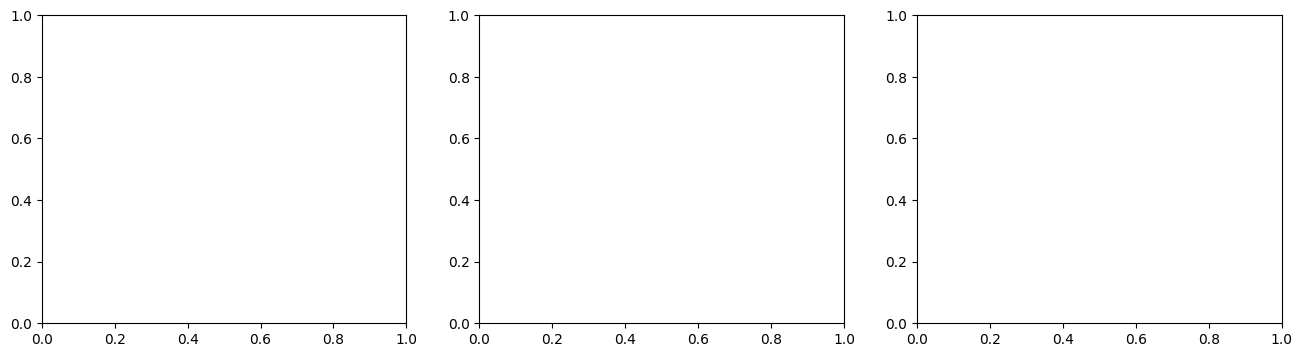

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel data into a DataFrame
df = pd.read_excel(excel_filename)

# Print columns and a few rows to verify the data (optional)
print("Columns in dataset:", df.columns.tolist())
print(df.head(5))

# Create a copy for analysis and preprocess data
df_analysis = df.copy()

# Convert driver_memory from strings like "2g", "4g" to numeric (in GB)
df_analysis['driver_memory_gb'] = df_analysis['driver_memory'].str.replace('g', '', case=False).astype(int)

# Define performance metrics:
# Throughput: training throughput in records per second
df_analysis['throughput'] = df_analysis['train_throughput_records_s']

# Latency: average prediction latency per record (ms)
df_analysis['latency_ms'] = (df_analysis['pred_duration_s'] / df_analysis['test_count']) * 1000

# Resource Utilization: peak CPU usage (max of start and end)
df_analysis['cpu_util_percent'] = df_analysis[['cpu_usage_start_percent', 'cpu_usage_end_percent']].max(axis=1)

# Verify that 'file_size' column exists
if 'file_size' not in df_analysis.columns:
    raise KeyError("The expected column 'file_size' was not found in the dataset.")

# Convert 'file_size' to a numerical representation before applying pd.qcut
file_size_mapping = {'1k': 1000, '500k': 500000, '3m': 3000000, 'unknown': -1}
# You can adjust these values or add more mappings as needed
df_analysis['file_size_numeric'] = df_analysis['file_size'].map(file_size_mapping)

# Then, apply pd.qcut to the new numeric column:
df_analysis['file_size_bin'] = pd.qcut(df_analysis['file_size_numeric'], q=3, labels=['small', 'medium', 'large'],
                                      duplicates='drop')  # Handle potential duplicates
# Define factors and performance metrics
factors = ['num_cores', 'driver_memory_gb', 'parallelism']
metrics = ['throughput', 'latency_ms', 'cpu_util_percent']

# Create line graphs for each factor vs each performance metric, grouped by file size bins
for factor in factors:
    fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4), sharey=False)
    for ax, metric in zip(axes, metrics):
        # Group the data by the factor and file_size_bin and calculate the mean metric value
        grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()

        # For each file size bin, sort the data by factor and plot a line
        for file_size_bin in grouped['file_size_bin'].unique():
            subset = grouped[grouped['file_size_bin'] == file_size_bin]
            # Sort by the factor to ensure a connected line plot
            subset = subset.sort_values(by=factor)
            ax.plot(subset[factor], subset[metric], marker='o', label=f'File Size: {file_size_bin}')

        ax.set_xlabel(factor)
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} vs {factor}")
        ax.legend()

    fig.suptitle(f"Impact of {factor} on Performance Metrics\n(Line graphs grouped by File Size)", fontsize=14)
    plt.tight_layout()
    plt.show()


Columns in dataset: ['worker_count', 'worker_memory', 'parallelism', 'tuple_processing_rate', 'file_size', 'train_duration_s', 'train_count', 'train_throughput_records_s', 'pred_duration_s', 'test_count', 'pred_throughput_records_s', 'rmse', 'r2', 'cpu_usage_start_percent', 'cpu_usage_end_percent', 'mem_used_at_start_mb', 'mem_used_at_end_mb', 'timestamp']
   worker_count worker_memory  parallelism  tuple_processing_rate file_size  \
0             1            2g            2                   2000      500k   
1             1            2g            4                   4000      500k   
2             1            2g            8                   8000      500k   
3             1            4g            2                   2000      500k   
4             1            4g            4                   4000      500k   

   train_duration_s  train_count  train_throughput_records_s  pred_duration_s  \
0        197.897521       388521                 1963.243392        49.478030   
1   

<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()
<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()
<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped =

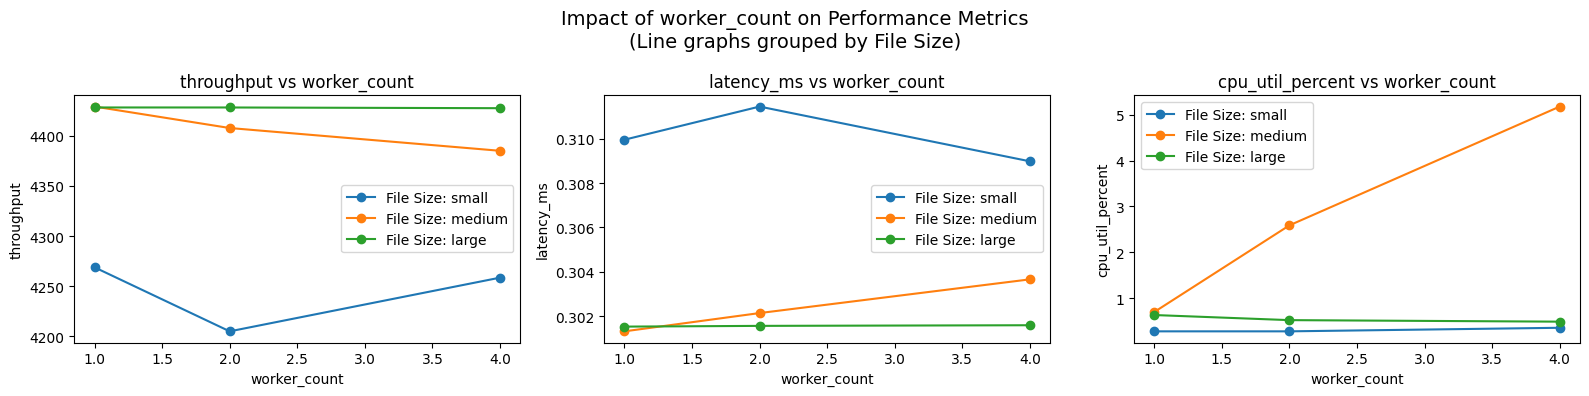

<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()
<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()
<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped =

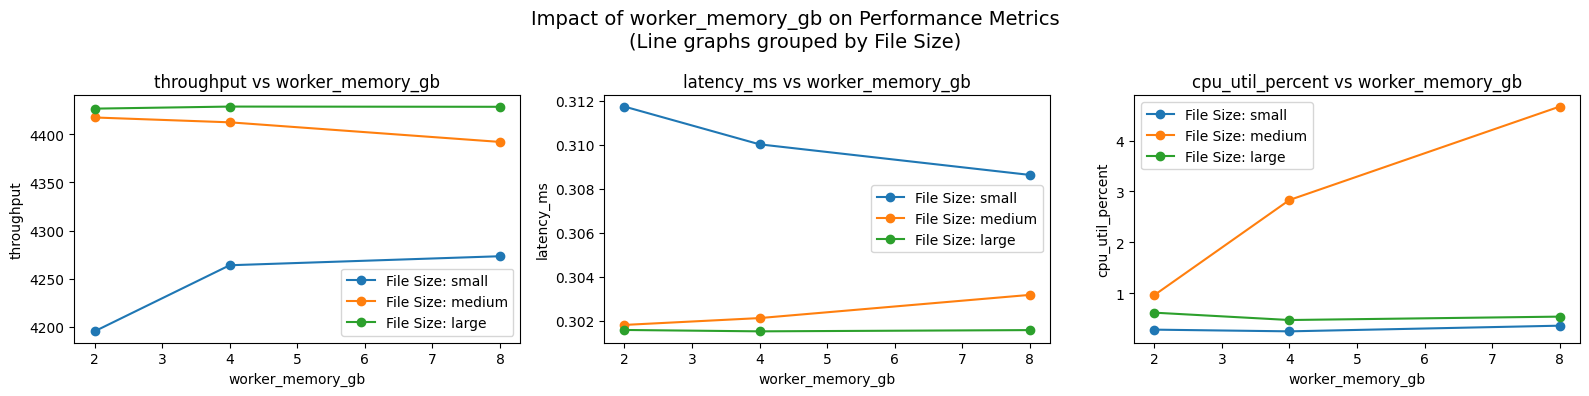

<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()
<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()
<ipython-input-6-bf130bf4d7b6>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped =

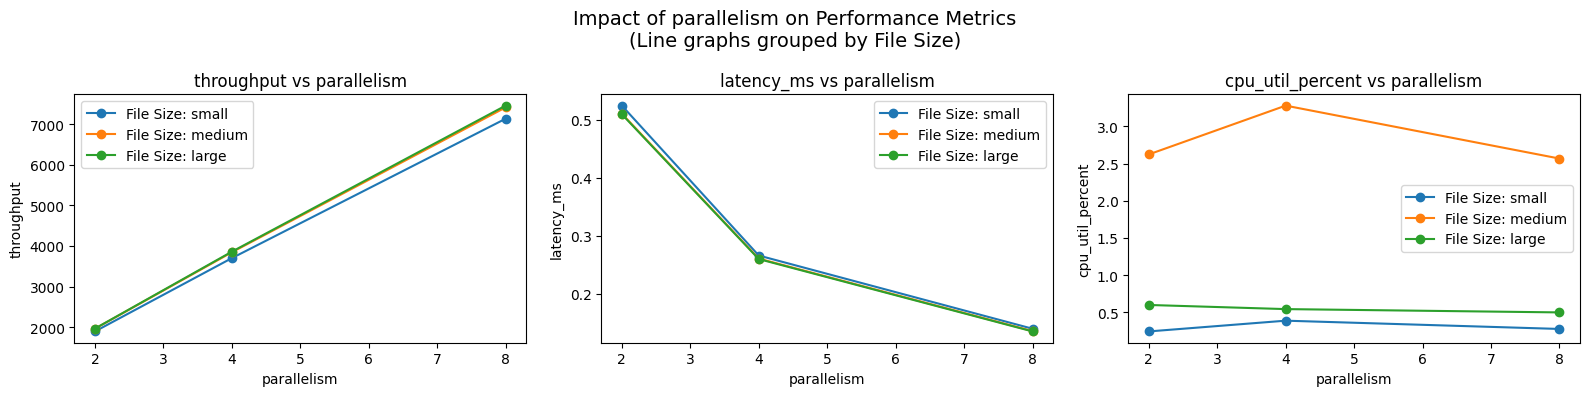

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel data into a DataFrame
df = pd.read_excel(excel_filename)

# Print columns and a few rows to verify the data (optional)
print("Columns in dataset:", df.columns.tolist())
print(df.head(5))

# Create a copy for analysis and preprocess data
df_analysis = df.copy()

# Convert worker_memory from strings like "2g", "4g" to numeric (in GB)
df_analysis['worker_memory_gb'] = df_analysis['worker_memory'].str.replace('g', '', case=False).astype(int)

# Define performance metrics
df_analysis['throughput'] = df_analysis['train_throughput_records_s']
df_analysis['latency_ms'] = (df_analysis['pred_duration_s'] / df_analysis['test_count']) * 1000
df_analysis['cpu_util_percent'] = df_analysis[['cpu_usage_start_percent', 'cpu_usage_end_percent']].max(axis=1)

# Verify that 'file_size' column exists
if 'file_size' not in df_analysis.columns:
    raise KeyError("The expected column 'file_size' was not found in the dataset.")

# Convert 'file_size' to a numerical representation before applying pd.qcut
file_size_mapping = {'1k': 1000, '500k': 500000, '3m': 3000000, 'unknown': -1}
df_analysis['file_size_numeric'] = df_analysis['file_size'].map(file_size_mapping)

# Bin file sizes into terciles
df_analysis['file_size_bin'] = pd.qcut(df_analysis['file_size_numeric'], q=3, labels=['small', 'medium', 'large'], duplicates='drop')

# Define factors and performance metrics
factors = ['worker_count', 'worker_memory_gb', 'parallelism']
metrics = ['throughput', 'latency_ms', 'cpu_util_percent']

# Create line graphs for each factor vs each performance metric, grouped by file size bins
for factor in factors:
    fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4), sharey=False)
    for ax, metric in zip(axes, metrics):
        grouped = df_analysis.groupby([factor, 'file_size_bin'])[metric].mean().reset_index()
        for file_size_bin in grouped['file_size_bin'].unique():
            subset = grouped[grouped['file_size_bin'] == file_size_bin].sort_values(by=factor)
            ax.plot(subset[factor], subset[metric], marker='o', label=f'File Size: {file_size_bin}')
        ax.set_xlabel(factor)
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} vs {factor}")
        ax.legend()

    fig.suptitle(f"Impact of {factor} on Performance Metrics\n(Line graphs grouped by File Size)", fontsize=14)
    plt.tight_layout()
    plt.show()

